<a href="https://colab.research.google.com/github/yuvalira/Monet_style_transfer/blob/main/data/EDA_monet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA — Monet Style Transfer Project**

**Dataset: [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started)**

The dataset contains two unpaired image domains stored in **TFRecord** format:

- **Monet-style paintings** (`monet_tfrec`)
- **Real-world landscape photos** (`photo_tfrec`)

Each image is stored as a **256×256×3** tensor.  
Our goal is to translate real photos into Monet-style paintings.

---

The preprocessing and EDA in this notebook include:

1. **Downloading** the dataset from Kaggle.  
2. **Loading** Monet and Photo datasets from TFRecords.  
3. **EDA and visualization**, including:  
   - Counting dataset shards and total image records.  
   - Inspecting image shapes and pixel value ranges.  
   - Displaying side-by-side samples from both domains.  
   - Showing random grids of images from each domain.  
   - Plotting pixel value histograms.

## 1. Setup

In [1]:
!pip install tensorflow-addons

In [2]:
!pip install keras==2.15.0 tensorflow==2.15.0 tensorflow-addons==0.23.0

Import dependencies

In [8]:
# Standard library
import sys
import random
from pathlib import Path

# Third-party packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

Configure Kaggle API access

In [5]:
!pip -q install kaggle

import os, json
from google.colab import files

print("Please upload your kaggle.json (from https://www.kaggle.com/settings/account)")
uploaded = files.upload()  # choose kaggle.json
assert "kaggle.json" in uploaded, "kaggle.json is required."

os.makedirs("/root/.kaggle", exist_ok=True)
with open("kaggle.json", "r") as f:
    creds = json.load(f)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(creds, f)
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("Kaggle API is configured.")

Please upload your kaggle.json (from https://www.kaggle.com/settings/account)


Saving kaggle.json to kaggle.json
Kaggle API is configured.


## 2. Load Dataset



In [6]:
# Download the competition bundle
!kaggle competitions download -c gan-getting-started -p ./kaggle -q

# Unzip the main archive into ./kaggle
!unzip -q ./kaggle/gan-getting-started.zip -d ./kaggle

# Create target folders for TFRecords
!mkdir -p ./tfrecords/monet_tfrec ./tfrecords/photo_tfrec

# Some competitions bundle TFRecords inside their own zip files.
# Try to unzip monet_tfrec and photo_tfrec zips if they exist:
!if [ -f ./kaggle/monet_tfrec.zip ]; then unzip -q ./kaggle/monet_tfrec.zip -d ./tfrecords/monet_tfrec; fi
!if [ -f ./kaggle/photo_tfrec.zip ]; then unzip -q ./kaggle/photo_tfrec.zip -d ./tfrecords/photo_tfrec; fi

# If TFRecords were extracted as folders under ./kaggle (not zipped),
# copy them into the standard structure:
!if [ -d ./kaggle/monet_tfrec ]; then cp -r ./kaggle/monet_tfrec/* ./tfrecords/monet_tfrec/; fi
!if [ -d ./kaggle/photo_tfrec ]; then cp -r ./kaggle/photo_tfrec/* ./tfrecords/photo_tfrec/; fi

# Verify
import glob, os
monet_tfrec = glob.glob("./tfrecords/monet_tfrec/*.tfrec")
photo_tfrec = glob.glob("./tfrecords/photo_tfrec/*.tfrec")
print("Monet TFRecord shards:", len(monet_tfrec))
print("Photo TFRecord shards:", len(photo_tfrec))
assert len(monet_tfrec) > 0 and len(photo_tfrec) > 0, "TFRecord files not found. Check unzip paths."

Monet TFRecord shards: 5
Photo TFRecord shards: 20


## 4. Dataset EDA

Monet images: 300
Photo images: 7038
Example image shape: (256, 256, 3)
Value range: -1.0 to 1.0


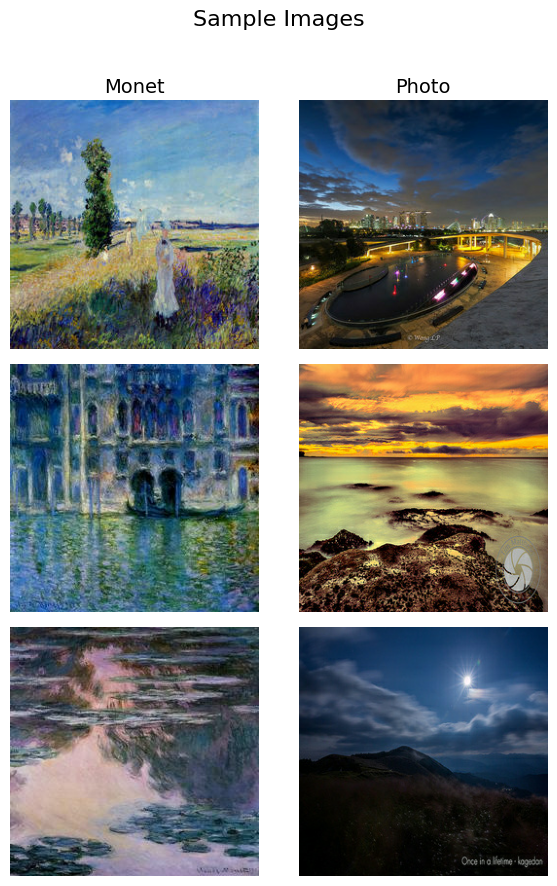

[Photo] 25165824 pixels → mean=-0.1887, std=0.5547, min=-1.000, max=1.000
[Monet] 25165824 pixels → mean=0.0121, std=0.4741, min=-1.000, max=1.000


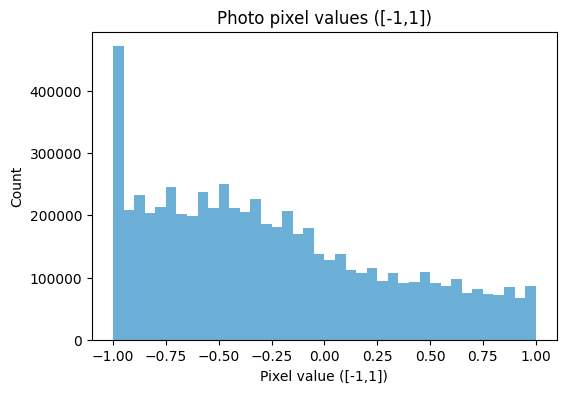

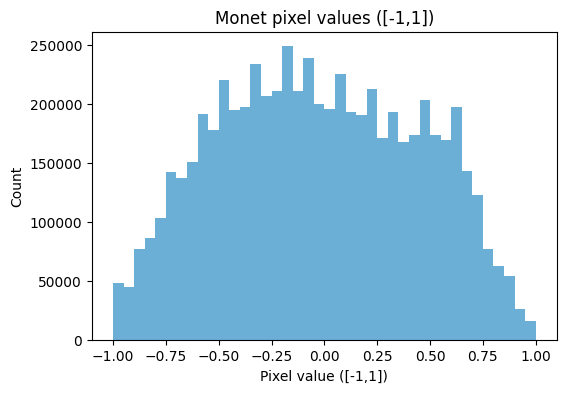

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (256, 256)

_TFREC_FEATURES = {
    "image_name": tf.io.FixedLenFeature([], tf.string),
    "image": tf.io.FixedLenFeature([], tf.string),
    "target": tf.io.FixedLenFeature([], tf.string),
}

def _decode_image(image_bytes: tf.Tensor) -> tf.Tensor:
    img = tf.image.decode_jpeg(image_bytes, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32) / 127.5 - 1.0   # [-1, 1]
    return img

def _parse_image_only(example: tf.Tensor) -> tf.Tensor:
    ex = tf.io.parse_single_example(example, _TFREC_FEATURES)
    return _decode_image(ex["image"])

def _load_all(domain_dir: str) -> tf.data.Dataset:
    files = tf.io.gfile.glob(f"{domain_dir}/*.tfrec")
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    ds = ds.map(_parse_image_only, num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

# Paths to dataset
monet_dir = "./tfrecords/monet_tfrec"
photo_dir = "./tfrecords/photo_tfrec"

monet_ds = _load_all(monet_dir)
photo_ds = _load_all(photo_dir)

# Image counts
def _count_records(domain_dir: str) -> int:
    files = tf.io.gfile.glob(f"{domain_dir}/*.tfrec")
    return sum(1 for _ in tf.data.TFRecordDataset(files))

n_monet = _count_records(monet_dir)
n_photo = _count_records(photo_dir)
print(f"Monet images: {n_monet}")
print(f"Photo images: {n_photo}")

# Sanity check: shape/range
sample_img = next(iter(monet_ds.take(1))).numpy()
print("Example image shape:", sample_img.shape)
print("Value range:", float(sample_img.min()), "to", float(sample_img.max()))

# Visualization: Monet–Photo sample grid
def _to_list(ds, k=50):
    return list(ds.take(k))

def show_monet_photo_pairs(monet_ds, photo_ds, n_examples=3, seed=42,
                           left_title="Monet", right_title="Photo"):
    random.seed(seed)
    monet_samples = _to_list(monet_ds, 50)
    photo_samples = _to_list(photo_ds, 50)

    # Randomly select independent examples from each domain
    monet_pick = random.sample(monet_samples, n_examples)
    photo_pick = random.sample(photo_samples, n_examples)

    pairs = list(zip(monet_pick, photo_pick))

    fig, axes = plt.subplots(n_examples, 2, figsize=(6, 3 * n_examples))
    fig.suptitle("Sample Images", fontsize=16)

    for i, (monet_img, photo_img) in enumerate(pairs):
        for col, (img, title) in enumerate([(monet_img, left_title), (photo_img, right_title)]):
            # handle batched vs single tensor
            if isinstance(img, (tuple, list)):
                img = img[0]
            if len(img.shape) == 4:
                img = img[0]
            # [-1,1] -> [0,1]
            img_show = ((img + 1.0) * 0.5).numpy()
            axes[i, col].imshow(np.clip(img_show, 0, 1))
            axes[i, col].axis("off")
            if i == 0:
                axes[i, col].set_title(title, fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

show_monet_photo_pairs(monet_ds, photo_ds, n_examples=3)


# Pixel statistics & histogram
def pixel_stats(ds, k=128, name="dataset"):
    vals = []
    for i, img in enumerate(ds.take(k)):
        if isinstance(img, (tuple, list)):
            img = img[0]
        if len(img.shape) == 4:
            img = img[0]
        vals.append(img.numpy().ravel())
    vals = np.concatenate(vals)
    print(f"[{name}] {vals.size} pixels → mean={vals.mean():.4f}, std={vals.std():.4f}, "
          f"min={vals.min():.3f}, max={vals.max():.3f}")

def show_histogram(ds, k=16, bins=40, title="Pixel value histogram"):
    vals = []
    for img in ds.take(k):
        if isinstance(img, (tuple, list)):
            img = img[0]
        if len(img.shape) == 4:
            img = img[0]
        vals.append(img.numpy().ravel())
    vals = np.concatenate(vals)
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=bins, color="#6baed6")
    plt.title(title)
    plt.xlabel("Pixel value ([-1,1])")
    plt.ylabel("Count")
    plt.show()

pixel_stats(photo_ds, k=128, name="Photo")
pixel_stats(monet_ds, k=128, name="Monet")
show_histogram(photo_ds, k=32, title="Photo pixel values ([-1,1])")
show_histogram(monet_ds, k=32, title="Monet pixel values ([-1,1])")